# Heat Exchanger

Story/Vorturnen

- Adiabaten Wärmetauscher, der Wärme vollständig von Fluid a auf Fluid b transportiert
- Wo ist da ein Energieverlust?
- Beispiel mit Temperaturen/Temperaturniveaus, es ist nicht umkehrbar!
- Exergieanalyse zeigt auch hier Qualitätsverlust
- 1 kleines Beispiel für die Berechnung + Plots der Exergieverluste

Übung

- Berechnung von Fuel/Product/Destruction/Wirkungsgrad (Verweis auf Grundlagen) mit allen T > T0
- Änderung von T0 aber immernoch T > T0 analysieren, Parameteranalyse?
- Wie spielen Druckverluste eine Rolle?
- Kondensation/Verdampfung?
- Wärmeübetragung vollständig unter T0 berechnen, hierzu Story erzählen, was Nutzen und Aufwand sind.

## Introduction

A heat exchanger is used to transfer heat from one fluid to a different one. We can write the energy balance for the component assuming, that no heat is lost to the ambient.

```{math}
    :label: heat-exchanger-energy-balance
    0 = \dot m_1 \cdot \left(h_\text{1,out} - h_\text{1,in}\right) + \dot m_2 \cdot \left(h_\text{2,out} - h_\text{2,in}\right)
```

The hot side {math}`1` transfers heat to the cold side {math}`2`. We can see, that all heat provided by the hot side is transferred to the cold side. However, in this process it is not possible to reach the same temperature level on the cold side as on the hot side. Reversing the heat transfer is for the same reason not possible: You cannot transfer heat against the direction of the temperature gradient. That obviously means, that the heat transfer incurs thermodynamic losses. To make them visible, we will again calculate the exergy of each of the flows.


## Example: Radiator

As an example we want to have a look at a home heating system that uses centralized distric heat as a source. To separate the district heating system from the home system, a heat exchangers is set in place. The radiator of the home system needs a feed flow temperature of {math}`70` degrees Celsius. By transfering heat to the home, its temperature reduces by {math}`15` Kelvin. The district heating system provides a flow of {math}`1 \frac{kg}{s}` with a temperature of {math}`90` degrees Celsius. It returns back with a temperature of {math}`50` degrees Celsius.


In [40]:
from CoolProp.CoolProp import PropsSI as PSI

# Properties of hot side fluid
fluid_1 = 'water'
m_dot_1 = 1  # kg/s
p_1 = (1.013 + 8) * 1e5  # Pa
T_in_1 = 90 + 273.15  # K
T_out_1 = 50 + 273.15  # K

# Properties of cold side fluid
fluid_2 = 'water'
p_2 = 1.013 * 1e5  # Pa
T_in_2 = 55 + 273.15  # K
T_out_2 = 70 + 273.15  # K


Let's find out how much water is flowing through the home heating system. To employ equation {eq}`heat-exchanger-energy-balance`, we have to get the specific enthalpies of our fluids.

In [41]:
h_in_1 = PSI('H', 'P', p_1, 'T', T_in_1, fluid_1)
h_out_1 = PSI('H', 'P', p_1, 'T', T_out_1, fluid_1)

h_in_2 = PSI('H', 'P', p_2, 'T', T_in_2, fluid_2)
h_out_2 = PSI('H', 'P', p_2, 'T', T_out_2, fluid_2)

m_dot_2 = m_dot_1 * (h_out_1 - h_in_1) / -(h_out_2 - h_in_2)

m_dot_2

2.668658947365666

The home heating system mass flow is about {math}`2.67 \frac{kg}{s}`, which makes sense due to the temperature spread of the radiator being smaller, than that of the district heat. After this calculation, we have all the information we need to calculate the physical exergy of both flows. For that we can use the function we built within the {ref}`ref:sec:adiabatic-pipe-flow` example. But first, we have to define an ambiant state:

In [42]:
# Ambiant state
p0 = 1.013 * 1e5  # Pa
T0 = 20 + 273.15  # K


```{tip}
We have provided the function to calculate the exergy in the 'utilities' file in this directory, so we can import it from there instead of redefining it here.
```

In [43]:
from utilities import calc_physical_exergy


ex_in_1 = calc_physical_exergy(p_1, h_in_1, p0, T0, fluid_1)
ex_out_1 = calc_physical_exergy(p_1, h_out_1, p0, T0, fluid_1)
ex_in_2 = calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2)
ex_out_2 = calc_physical_exergy(p_2, h_out_2, p0, T0, fluid_2)

In this specific case, all fluid temperatures are above our ambiant temperature. This means, that the following equations describe the fuel and product exergies:

```{math}
    :label: e_f-all-T-above-T0
    E_F = E^{PH}_{in,1} - E^{PH}_{out,1} + E^{M}_{in,2} - E^{M}_{out,2}
```

```{math}
    :label: e_p-all-T-above-T0
    E_P = E^{T}_{out,2} - E^{T}_{in,2}
```

Let's calculate them.

In [44]:
ex_F = sum(ex_in_1) - sum(ex_out_1) + ex_in_2[1] - ex_out_2[1]
ex_P = ex_out_2[0] - ex_in_2[0]

ex_F, ex_P

(24262.515129680556, 7942.124726498878)

The fuel exergy comes out to about {math}`24.27 \frac{kJ}{kg}` and the product exergy to about {math}`7.942 \frac{kJ}{kg}`. With these values, we can finally calculate exergy destruction, exergy destruction ratio and exergy efficiency. That works analogously as described in {ref}`ref:sec:adiabatic-pipe-flow`.

In [45]:
ex_D = ex_F - ex_P
y_D = ex_D / ex_F
eta_ex = ex_P / ex_F

ex_D, y_D, eta_ex

(16320.390403181678, 0.6726586388901122, 0.32734136110988776)

The total exergy destruction is about {math}`16.32 \frac{kJ}{kg}`, resulting in an exergy destruction ratio of about {math}`67.3` % and an exergy efficiency of about {math}`32.7` %.

## Example: Underfloor heating

Now lets compare the radiator with an underfloor heating system. Typically, these work at a feed flow temperature of {math}`40` degrees Celsius with a temperature spread of {math}`10` K.

In [46]:
T_in_2_uf = 30 + 273.15  # K
T_out_2_uf = 40 + 273.15  # K

h_in_2_uf = PSI('H', 'P', p_2, 'T', T_in_2_uf, fluid_2)
h_out_2_uf = PSI('H', 'P', p_2, 'T', T_out_2_uf, fluid_2)

What do you expect the result of the exergy analysis of the underfloor heater to be in comparison to the radiator. How do the lower system temperatures affect the fuel and product exergy? Take a guess before continuing.

Let's calculate the physical, as well as the fuel and product exergies.

In [47]:
ex_in_2_uf = calc_physical_exergy(p_2, h_in_2_uf, p0, T0, fluid_2)
ex_out_2_uf = calc_physical_exergy(p_2, h_out_2_uf, p0, T0, fluid_2)

ex_F_uf = sum(ex_in_1) - sum(ex_out_1) + ex_in_2_uf[1] - ex_out_2_uf[1]
ex_P_uf = ex_out_2_uf[0] - ex_in_2_uf[0]


With these, we can calculate exergy destruction, exergy destruction ratio and exergy efficiency again.

In [48]:
ex_D_uf = ex_F_uf - ex_P_uf
y_D_uf = ex_D_uf / ex_F_uf
eta_ex_uf = ex_P_uf / ex_F_uf

ex_D_uf, y_D_uf, eta_ex_uf

(22231.59449706795, 0.916293895263638, 0.08370610473636197)

The total exergy destruction is about {math}`22.23 \frac{kJ}{kg}`, resulting in an exergy destruction ratio of about {math}`91.6` % and an exergy efficiency of about {math}`8.4` %. That's an **increase** in exergy destruction by around {math}`36.2` %.

Do the results match your expectations? What does this say about the process of providing heat to the underfloor system from the district heating system? How could a dhs operator reduce exergy destruction in home systems in general?

## Analysis of examples

For a better understanding of the mechanisms at work, let's visualize the continuous change of exergy destruction when the home heating systems feed flow temperature is raised from the one of the underfloor heater to the respective one of the radiator (constant temperature spread of {math}`15` Kelvin assumed). To go even further, let us also reduce the district heating systems feed flow temperature stepwise.

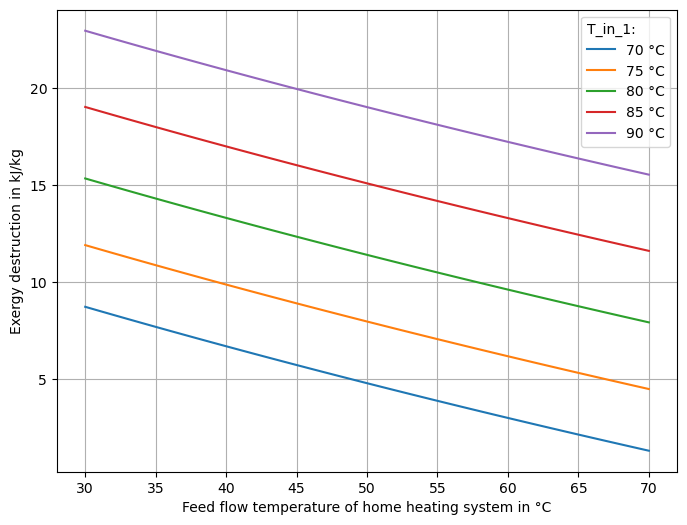

In [49]:
import matplotlib.pyplot as plt

# Prepare data
T_outs_2 = [T_out_2 + 273.15 for T_out_2 in range(30, 71)]
T_ins_2 = [T_out_2 - 15 for T_out_2 in T_outs_2]

h_outs_2 = [PSI('H', 'P', p_2, 'T', T_out_2, fluid_2) for T_out_2 in T_outs_2]
h_ins_2 = [PSI('H', 'P', p_2, 'T', T_in_2, fluid_2) for T_in_2 in T_ins_2]

ex_outs_2 = [calc_physical_exergy(p_2, h_out_2, p0, T0, fluid_2) for h_out_2 in h_outs_2]
ex_ins_2 = [calc_physical_exergy(p_2, h_in_2, p0, T0, fluid_2) for h_in_2 in h_ins_2]

T_ins_1 = [T_in_1 + 273.15 for T_in_1 in range(70, 95, 5)]

h_ins_1 = [PSI('H', 'P', p_2, 'T', T_in_1, fluid_1) for T_in_1 in T_ins_1]

ex_ins_1 = [calc_physical_exergy(p_2, h_in_1, p0, T0, fluid_1) for h_in_1 in h_ins_1]

ex_Ds = list()
for ex_in_1 in ex_ins_1:
    ex_Fs = [
        sum(ex_in_1) - sum(ex_out_1) + ex_in_2[1] - ex_out_2[1]
        for ex_out_2, ex_in_2 in zip(ex_outs_2, ex_ins_2)
        ]
    ex_Ps = [ex_out_2[0] - ex_in_2[0] for ex_out_2, ex_in_2 in zip(ex_outs_2, ex_ins_2)]
    ex_Ds += [[(ex_F - ex_P) * 1e-3 for ex_F, ex_P in zip(ex_Fs, ex_Ps)]]

# Generate plot
fig, ax = plt.subplots(figsize=(8, 6))

T_outs_2_Celsius = [T_out - 273.15 for T_out in T_outs_2]

for idx, T_in_1 in enumerate(T_ins_1):
    ax.plot(T_outs_2_Celsius, ex_Ds[idx], label=f'{T_in_1-273.15:.0f} °C')

ax.set_xlabel('Feed flow temperature of home heating system in °C')
ax.set_ylabel('Exergy destruction in kJ/kg')
ax.legend(title='T_in_1:', alignment='left')
ax.grid()
ax.set_axisbelow(True)


As we can see, the exergy destruction is lowest, when the cold side's outflow temperature is closest to the hot side's inflow temperature (when all temperatures are above the ambiant temperature). This means, that ideally the feed flow temperature of a district heating system should be as close to the target heating temperature as possible. Exergy destruction and heat losses in transmission are the main reason dhs operators aim at lowering their system temperatures (see: LowEx, 4th and 5th generation of district heating). Also, we can see a slight non-linearity in both each line as well as between the lines, with a lower slope at lower temperatures. This is due to the thermodynamic properties of water, with the specific enthalpy and especially the specific entropy not increasing at a constant rate with rising temperature for a given pressure.

## Exercises

1. 
2. 
3. 

## Lessons Learned

- What did you learn?
- What should you be able to apply yourself?